In [1]:
%matplotlib inline

import sys, os
sys.path.append(os.path.abspath(os.path.join('..', 'src/')))
from sgpi.util import get_dataset, get_xy, get_r_squared, split, to_data_matrix
from sgpi.plot import *

from sgpi import model
from sgpi.learner import SGRegressionLearner

import pandas as pd
import pysgpp as sg

from scipy.sparse.linalg import LinearOperator, svds, aslinearoperator
from scipy.linalg import svd

In [2]:
#TODO extract to its own file, is from 017-RegularizationHeat!
def decode(num):
    zeros = np.zeros(len(num)) + 0.5
    return np.equal(zeros, num)

def coords_to_pred(coords):
    s = ""
    for i, c in enumerate(coords):
        if not c:
            s = s + "x{} ".format(i)
    s = s.strip()
    if s == "":
        return "bias"
    else:
        s = s.replace(" ", "-")
        return s

def group_weights_raw(grid):
    storage = grid.getStorage()
    dim = storage.getDimension()

    coords = []
    for x in range(0, grid.getSize()):
        gen0 = storage.get(x)
        curCoords = []
        for i in range(0,dim):
            curCoords.append(gen0.getCoord(i))
        curCoords = np.array(curCoords)
        coords.append(curCoords)


    terms = {}
    groups = {}
    terms_nums = []
    for num, r in enumerate(coords):
        d = tuple(decode(r))
        if d not in terms:
            terms[d] = []
            groups[d] = len(groups)
        terms[d].append(num)
        terms_nums.append(groups[d])
    
    return terms

def group_weights_format(grid):
    terms = group_weights_raw(grid)
    return dict([(coords_to_pred(coords), terms[coords]) for coords in terms])

def group_list(grid):
    groups = group_weights_format(grid)
    glist = [None] * (grid.getSize())
    for group in groups:
        for i in groups[group]:
            glist[i] = group
    return glist

In [3]:
def get_Phi(grid, X_train):
    def eval_op(x, op, size):
        result_vec = sg.DataVector(size)
        x = sg.DataVector(np.array(x).flatten())
        op.mult(x, result_vec)
        return result_vec.array().copy()

    def eval_op_transpose(x, op, size):
        result_vec = sg.DataVector(size)  
        x = sg.DataVector(np.array(x).flatten())
        op.multTranspose(x, result_vec)
        return result_vec.array().copy()

    data_train = to_data_matrix(X_train)
    data_test = to_data_matrix(X_test)

    num_elem = X_train.shape[0]

    op = sg.createOperationMultipleEval(grid, data_train)
    matvec = lambda x: eval_op(x, op, num_elem)
    rmatvec = lambda x: eval_op_transpose(x, op, grid.getSize())

    shape = (num_elem, grid.getSize())
    linop = LinearOperator(shape, matvec, rmatvec, dtype='float64')

    y_sg = np.matrix(y_train).T
    x_sg = np.matrix(np.zeros(grid.getSize())).transpose()
    Phi = linop.matmat(np.matrix(np.identity(grid.getSize())))
    return Phi

In [4]:
df = get_dataset('concrete')
df_train, df_test = split(df)
X_train, y_train = get_xy(df_train)
X_test, y_test = get_xy(df_test)

level = 2
l1_ratio = 1.0

In [5]:
grid = sg.Grid.createModLinearGrid(X_train.shape[1])
gen = grid.getGenerator()
gen.regular(level)

In [6]:
Phi = get_Phi(grid, X_train)

In [7]:
def get_max_lambda(Phi, y, l1_ratio=1.0):
    max_prod = 0
    for i in range(0, grid.getSize()):
        a = np.asarray(Phi[:,i]).flatten()
        prod = np.inner(a, y)
        max_prod = max(max_prod, prod)
    max_lambda = max_prod/(l1_ratio)
    return max_lambda

In [8]:
max_lambda = get_max_lambda(Phi, y_train, l1_ratio)

In [9]:
max_lambda, Phi.shape, y_train.shape, X_train.shape

(32261.689836957015, (824, 17), (824,), (824, 8))

In [10]:
grid_config = model.GridConfig(type=6, level=level, T=0)
adaptivity_config = model.AdaptivityConfig(num_refinements=0, no_points=0, treshold=0.0, percent=0.0)
#reg_type = sg.RegularizationType_ElasticNet
reg_type = sg.RegularizationType_GroupLasso
solv_type = sg.SLESolverType_FISTA

solver_config = model.SolverConfig(type=solv_type, max_iterations=400, epsilon=0, threshold=10e-8)
final_solver_config = solver_config

regularization_config = model.RegularizationConfig(type=reg_type, exponent_base=1, lambda_reg=max_lambda, l1_ratio=l1_ratio)

estimator = SGRegressionLearner(grid_config, regularization_config, solver_config,
                                final_solver_config, adaptivity_config)

In [11]:
estimator.fit(X_train, y_train)

In [12]:
-estimator.score(X_train, y_train)

1524.0237676345744

In [13]:
estimator.get_weights()

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [14]:
epsilon = 0.001
num_lambdas = 20 #00
min_lambda = epsilon * max_lambda
lambda_grid = np.logspace(np.log10(max_lambda), np.log10(min_lambda), num=num_lambdas)
min_lambda, lambda_grid, min_lambda/X_train.shape[0]

(32.261689836957018,
 array([ 32261.68983696,  22428.09436717,  15591.84963605,  10839.34154606,
          7535.43215813,   5238.57815242,   3641.82179377,   2531.76827599,
          1760.06706706,   1223.58594581,    850.62813503,    591.3505517 ,
           411.10264356,    285.79559629,    198.68303972,    138.12301794,
            96.02212706,     66.753891  ,     46.40682414,     32.26168984]),
 0.039152536209899294)

In [15]:
weights = []
for i, lamb in enumerate(lambda_grid):
    estimator.set_params(regularization_config__lambda_reg = lamb)
    print "Started training estimator {}".format(i)
    estimator.fit(X_train, y_train, estimator.get_weights()) # reuse old weights
    print "Finished training estimator {}".format(i)
    weights.append(estimator.get_weights())

Started training estimator 0
Finished training estimator 0
Started training estimator 1
Finished training estimator 1
Started training estimator 2
Finished training estimator 2
Started training estimator 3
Finished training estimator 3
Started training estimator 4
Finished training estimator 4
Started training estimator 5
Finished training estimator 5
Started training estimator 6
Finished training estimator 6
Started training estimator 7
Finished training estimator 7
Started training estimator 8
Finished training estimator 8
Started training estimator 9
Finished training estimator 9
Started training estimator 10
Finished training estimator 10
Started training estimator 11
Finished training estimator 11
Started training estimator 12
Finished training estimator 12
Started training estimator 13
Finished training estimator 13
Started training estimator 14
Finished training estimator 14
Started training estimator 15
Finished training estimator 15
Started training estimator 16
Finished train

In [26]:
df = pd.DataFrame(weights, index=lambda_grid)
df = df.transpose()
glist = group_list(grid)
df['group'] = glist
#df = df.div(df.abs().max(axis=0), axis=0)

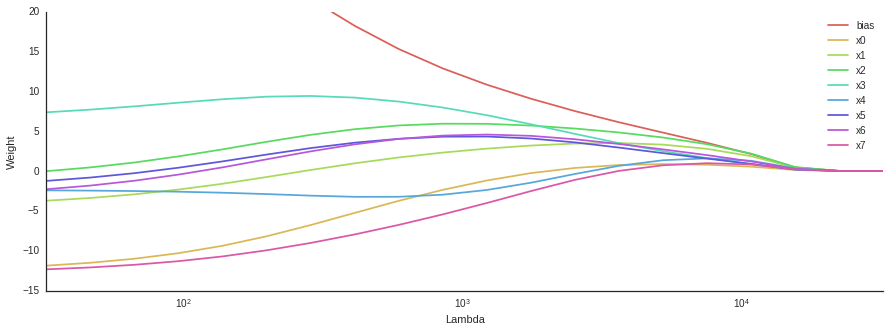

In [27]:
sns.set_palette(sns.color_palette("hls", len(set(glist))))
# ignore bias
fig, ax = plt.subplots(figsize=(15,5))
for group, data in df.groupby('group'):
    data = data.values[0][0:-1]
    ax.semilogx(lambda_grid, data, label=group)#c='grey')
lambdas = [np.min(lambda_grid), np.median(lambda_grid), np.max(lambda_grid)]
lambda_names = [l/X_train.shape[0] for l in lambdas]
ax.tick_params()
ax.set_xlabel("Lambda")
ax.set_ylabel("Weight")
ax.set_ylim(bottom=-15, top=20)
ax.set_xlim(left=lambda_grid[-1], right=lambda_grid[0])
ax.legend()
sns.despine(fig, ax)
